In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append("C:\\Program Files\\DIgSILENT\\PowerFactory 2024 SP4A\\Python\\3.12")
import powerfactory as PF
from powerfactory import DataObject

app = PF.GetApplicationExt()
if app is None:
    raise RuntimeError("PowerFactory application could not be started.")

app.Show()

In [2]:
# Get project folder
currentUser = app.GetCurrentUser()
folders = currentUser.GetContents("*.IntFolder", 0)
for folder in folders:
    if folder.GetAttribute("loc_name") == "RoCoF Optimization":
        projectFolder: DataObject = folder
        break

# Get .IntPrj in folder and activate it
project: DataObject = projectFolder.GetContents("*.IntPrj", 0)[0]
project.Activate() # type: ignore

# Active Study Case
activeCase: DataObject = app.GetActiveStudyCase()

In [3]:
from pf_python_api.Network import Network

busbars = app.GetCalcRelevantObjects("*.ElmTerm", 1, 1, 1)
print(f"Number of busbars: {len(busbars)}")

# Create Network object
network = Network()
network.read_busbars(busbars)
print(len(network.busbars))

# Get connected elements
connected_elements = network.get_connected_elements() 

# Print the amount of each element
for element_type, elements in network.classified_elements.items():
    print(f"{element_type}: {len(elements)}")

Number of busbars: 13
13
[INFO] Obtaining connected elements... in 13 busbars...
ElmLod: 8
ElmSym: 8
ElmLne: 12


In [4]:
from typing import Dict
from pf_python_api.LoadFlowResults import BusLoadFlowResult

# Create a load flow object and execute
ldf: DataObject = app.GetFromStudyCase("ComLdf")
ldf.Execute() # type: ignore 

# Store results using dataclass
bus_load_flow_results: Dict[str, BusLoadFlowResult] = {}
for busbar in busbars:
    name = busbar.GetAttribute("loc_name")
    voltage = busbar.GetAttribute("m:u")
    angle = busbar.GetAttribute("m:phiu")
    
    bus_load_flow_results[name] = BusLoadFlowResult(
        name=name,
        voltage=voltage,
        angle=angle
    )

# Store load flow to Network object
network.read_load_flow_results(bus_load_flow_results)
print(len(network.load_flow_results))

13


In [5]:
# After performing LF obtain all elements data
network.obtain_elements_data()

# Calculate admittance matrix
Y_bus = network.calculate_admittance_matrix()

Number of busbars: 13
Admittance matrix shape: (13, 13)
13


In [6]:
import numpy as np
# ----------- SORT ADMITTANCE MATRIX -----------
Y_red = Y_bus

# Get generator buses names 
generator_bus_names = [gen.busbar_to for gen in network.synchronous_machines] # ['Bus 36G', 'Bus 33G',..]
generator_names = [gen.name for gen in network.synchronous_machines] # ['G36', 'G33',..]

# Create a boolean array to check if the bus is a generator bus
isGenBus = np.array([1 if bus.name in generator_bus_names else 0 for bus in network.busbars])

# Create a list of bus names
bus_names = [bus.name for bus in network.busbars]
# Create sorted indices with non-generator buses first and generator buses appended
sorted_indices = sorted(range(len(bus_names)), key=lambda i: bus_names[i] in generator_bus_names)

# Reindex Y_red to have non-generator buses first and generator buses second
Y_red_sorted = Y_red[np.ix_(sorted_indices, sorted_indices)] 
Y_red = Y_red_sorted # Update Y_red with the sorted version

# ----------- BUILD EXTENDED MATRIX FOR KRON'S REDUCTION -----------
# Navidezne generatorske zbiralke
y_red = np.eye(np.sum(isGenBus), dtype=complex)
for i, gen in enumerate(network.synchronous_machines):
    y_red[i, i] = gen.Y

# Povezave na navidezne generatorske zbiralke
y_red2 = -y_red

# Ne-generatorske zbiralke, ki nimajo povezave na generatorske zbiralke
y_dist = np.zeros((np.sum(isGenBus == 1), np.sum(isGenBus == 0))) 

num_gen_buses = np.sum(isGenBus) # Calculate the number of generator buses
num_total_buses = Y_red.shape[0] # Calculate the total number of buses
red_id = np.arange(num_gen_buses, num_total_buses + num_gen_buses) # Generate the indices to reduce

# Build extended matrix
top_right = np.hstack((y_dist, y_red2))
bottom_left = np.vstack((y_dist.T, y_red2))
Yred = np.block([
    [y_red,         top_right],
    [bottom_left,  Y_red     ]
])
YredX = Yred

# ----------- PERFORM KRON'S REDUCTION -----------
def KronReduction3(Y, p):
    # Extracting sub-blocks
    Y_RR = Y[:p, :p]
    Y_RL = Y[:p, p:]
    Y_LR = Y[p:, :p]
    Y_LL = Y[p:, p:]
    
    # Compute the inverse of Y_LL (assuming it is invertible)
    Y_LL_inv = np.linalg.inv(Y_LL)
    
    # Compute Y_Reduced using the Schur complement
    Y_Reduced = Y_RR - Y_RL @ Y_LL_inv @ Y_LR

    # Y_Reduced = Y_RR - Y_RL @ np.linalg.solve(Y_LL, Y_LR)
    
    return Y_Reduced

print("Performing Kron's Reduction... on YredX shaped: ", np.shape(YredX), " with num_gen_buses: ",num_gen_buses)
Y_reduced = KronReduction3(YredX, num_gen_buses)
print("After Kron's Reduction we obtain Y_reduced with shape: ", np.shape(Y_reduced))

# Print the reduced admittance matrix
for row in Y_reduced:
    print("    ".join(f"{val:.2f}" for val in row))

Performing Kron's Reduction... on YredX shaped:  (21, 21)  with num_gen_buses:  8
After Kron's Reduction we obtain Y_reduced with shape:  (8, 8)
16.94-284.24j    13.52+75.91j    16.70+96.50j    10.31+44.35j    3.87+11.79j    2.40+6.04j    1.55+3.27j    1.17+2.15j
13.52+75.91j    15.33-290.67j    11.91+50.78j    13.27+80.53j    5.54+21.54j    3.58+11.07j    2.40+6.04j    1.84+3.99j
16.70+96.50j    11.91+50.78j    21.52-239.69j    8.59+29.58j    3.04+7.82j    1.84+3.99j    1.17+2.15j    0.87+1.41j
10.31+44.35j    13.27+80.53j    8.59+29.58j    15.95-272.88j    8.06+41.72j    5.54+21.54j    3.87+11.79j    3.04+7.82j
3.87+11.79j    5.54+21.54j    3.04+7.82j    8.06+41.72j    15.95-272.88j    13.27+80.53j    10.31+44.35j    8.59+29.58j
2.40+6.04j    3.58+11.07j    1.84+3.99j    5.54+21.54j    13.27+80.53j    15.33-290.67j    13.52+75.91j    11.91+50.78j
1.55+3.27j    2.40+6.04j    1.17+2.15j    3.87+11.79j    10.31+44.35j    13.52+75.91j    16.94-284.24j    16.70+96.50j
1.17+2.15j    1.84+3

In [7]:
# ----------- Calculate SYNCHRONIZING COEFFICIENTS -----------
B_K = np.imag(Y_reduced)
G_K = np.real(Y_reduced)

generatorBusOrder = generator_bus_names
# GET GENERATOR VOLTAGE AND IMPEDANCE
V_gens = np.zeros(len(generatorBusOrder), dtype=complex)
Z_gens = np.zeros(len(generatorBusOrder), dtype=complex)
for i, bus_name in enumerate(generatorBusOrder):
    for gen in network.synchronous_machines:
        if gen.busbar_to == bus_name:
            bus_name = gen.busbar_to

            # Get voltage and angle
            V = bus_load_flow_results[bus_name].voltage
            phi = bus_load_flow_results[bus_name].angle
            
            V_complex = V * (np.cos(np.radians(phi)) + 1j * np.sin(np.radians(phi)))
            V_gens[i] = V_complex

            Z = 1 / gen.Y
            Z_gens[i] = Z
            break

# GET GENERATOR ACTIVE AND REACTIVE POWER
P_gens = np.zeros(len(generatorBusOrder))
Q_gens = np.zeros(len(generatorBusOrder))
for i, bus_name in enumerate(generatorBusOrder):
    for gen in network.classified_elements['ElmSym']:
        # busbar_to = gen.GetAttribute()
        connected_terminal: DataObject = gen.GetAttribute("bus1")
        gen_bus_name = connected_terminal.GetParent().GetAttribute("loc_name")

        if gen_bus_name == bus_name:
            P = gen.GetAttribute("m:P:bus1")
            Q = gen.GetAttribute("m:Q:bus1")
            P_gens[i] = P
            Q_gens[i] = Q
            break

# GET GENERATOR INTERNAL VOLTAGE AND ANGLE
E = V_gens + Z_gens * (np.conj(P_gens + 1j * Q_gens) / np.conj(V_gens))
E_abs = np.abs(E)
E_angle = np.angle(E)

DistBus:  7
[0.01120703 0.02075258 0.00734798 0.04069276 0.15388471 0.26415681
 0.50195813 0.        ]
1.0
244.49217882227398


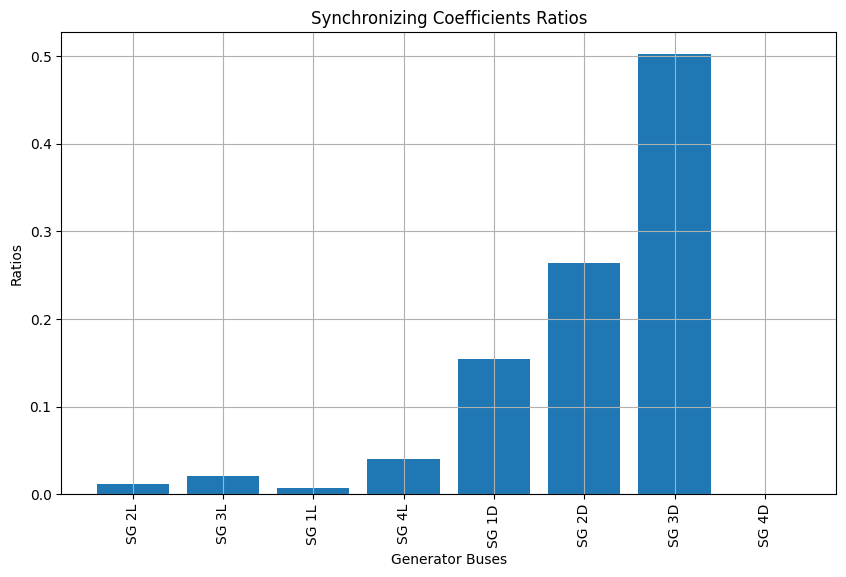

In [8]:
# CALCULATE THE SYNCHRONIZING COEFFICIENTS
GEN_OUT_NAME = "SG 4D"
DistBusName = None
for gen in network.synchronous_machines:
    if gen.name == GEN_OUT_NAME:
        DistBusName = gen.busbar_to
        break
if DistBusName is None:
    raise ValueError(f"Generator with name '{GEN_OUT_NAME}' not found.")
DistBus = generator_bus_names.index(DistBusName) # Disturbance bus index
print("DistBus: ", DistBus)

# Create the coefficient matrix K
K = (np.ones(Y_reduced.shape) * E_abs[DistBus] * E_abs *
     (B_K * np.cos(np.deg2rad(E_angle - np.ones(Y_reduced.shape)*E_angle[DistBus])) -
      G_K * np.sin(np.deg2rad(E_angle - np.ones(Y_reduced.shape)*E_angle[DistBus]))))
K[np.isnan(K)] = 0 # Replace NaN values with zero

# Reference is SG bus
K = K[:, DistBus] # Select the column at DistBus from matrix
K[DistBus] = 0 # Set the element at DistBus to zero

ratios = K / np.sum(K) # Compute ratios
print(ratios)
print(sum(ratios))
print(np.sum(K))

# Plot the ratios
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(generator_names, ratios)
plt.xlabel('Generator Buses')
plt.ylabel('Ratios')
plt.title('Synchronizing Coefficients Ratios')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [9]:
from powerRMS import getInitialPowerDistributionResults

oComReset = app.GetFromStudyCase("ComReset")
oComReset.Execute() # type: ignore
allGenerators = app.GetCalcRelevantObjects("*.ElmSym", 1, 1, 1)
GEN_OUT: DataObject = next(gen for gen in allGenerators if gen.GetAttribute("loc_name") == GEN_OUT_NAME)
# Get initial power distribution results
rdP = getInitialPowerDistributionResults(app, activeCase, allGenerators, GEN_OUT)
rdP

Active Generators:  8
Ime Rezultatov:  All calculations
Processing generator outage: SG 4D
The first row index where gen_out_name hits the minimum value is: 2103
The value at this index is: 1e-08
Values at the minimum index 2103 are: [9.19579754e+01 8.08154795e+01 1.01222732e+02 8.11322716e+01
 1.19527300e+02 8.19508097e+01 1.00000000e-08 8.33934351e+01]
Values at the index before the minimum index 2102 are: [80.00000017 80.00000248 79.99999886 79.99999865 79.99999865 79.99999886
 80.00000233 80.00000017]
The index of gen_out_name is: 7
Sum of substraction values: 80.00000492


,SG 1D,SG 1L,SG 2D,SG 2L,SG 3D,SG 3L,SG 4D,SG 4L
0,14.947468,1.019346,26.528415,1.415341,49.409123,2.438513,0.0,4.241793


['SG 2L', 'SG 3L', 'SG 1L', 'SG 4L', 'SG 1D', 'SG 2D', 'SG 3D', 'SG 4D']


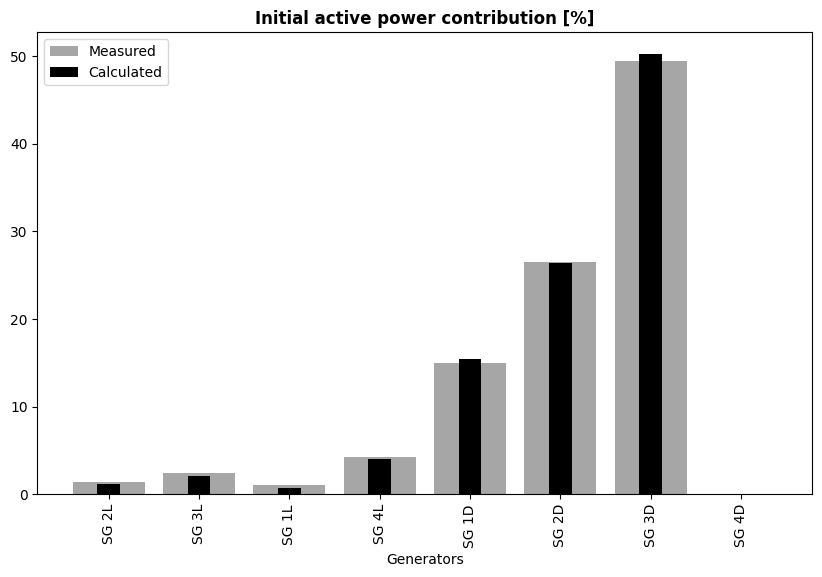

In [10]:
# Plot the rdP values
import matplotlib.pyplot as plt
rdP = rdP[generator_names]
plt.figure(figsize=(10, 6))
print(generator_names)
# gen_names = ["G1", "G3", "G4", "G0", "G2"]
bar2 = plt.bar(generator_names, rdP.iloc[0].values, 0.8, color='gray', label='Measured', alpha=0.7)
bar1 = plt.bar(generator_names, ratios*100, 0.25, color='black', label='Calculated', alpha=1)
plt.xlabel('Generators')
plt.title('Initial active power contribution [%]', fontweight='bold')
plt.xticks(rotation=90)
plt.grid(False)
plt.legend()
plt.show()

In [11]:
import pandas as pd

# Machines Inertia Constant H (rated so Sgn = 100 MVA)
# H = 1.5 # [s]
H = 0.8 # [s]
H = np.full(8, H)

# Power of the outage generator
delta_P = 0.8 # [MW]

# Power impact distribution K / sum(K)
powerDistribution = ratios

# Calculate the power distribution for each generator
ratiosPower = powerDistribution * delta_P

# RoCoF calculation
RoCoF = ratiosPower / (2 * H) # [p.u.]
RoCoF_rad = RoCoF * 2 *np.pi * 50 # [rad/s]
RoCoF_Hz = RoCoF_rad / (2 * np.pi) # [Hz/s]

df_rocof = pd.DataFrame([RoCoF_Hz], columns=generator_names, index=["RoCoF"])
df_rocof

,SG 2L,SG 3L,SG 1L,SG 4L,SG 1D,SG 2D,SG 3D,SG 4D
RoCoF,0.280176,0.518814,0.183699,1.017319,3.847118,6.60392,12.548953,0.0


In [12]:
mean = 0.8 / (2 * (np.sum(H)))
mean = mean * 2 * np.pi * 50 # [rad/s]
mean = mean / (2 * np.pi) # [Hz/s]
print("Mean RoCoF: ", mean)

Mean RoCoF:  3.125


In [13]:
from rocofRMS import getRocofResults
%reload_ext autoreload
oComReset = app.GetFromStudyCase("ComReset")
oComReset.Execute() # type: ignore
allGenerators = app.GetCalcRelevantObjects("*.ElmSym", 1, 1, 1)
results_pu, allData = getRocofResults(app, activeCase, allGenerators, GEN_OUT)

Active Generators:  8
Active Generators:  ['SG 1D', 'SG 1L', 'SG 2D', 'SG 2L', 'SG 3D', 'SG 3L', 'SG 4D', 'SG 4L']
Ime Rezultatov:  All calculations
Processing generator outage: SG 4D
Simulation finished.


In [14]:
results = results_pu * 50

In [15]:
results

,SG 1D,SG 1L,SG 2D,SG 2L,SG 3D,SG 3L,SG 4D,SG 4L
Smallest RoCoF,-4.604450,-0.578900,-7.414060,-0.734700,-13.759732,-1.095375,22.953854,-1.685675
Largest RoCoF,-3.442425,-0.237418,-6.090394,-0.328902,-9.232850,-0.565076,27.941783,-0.980850


In [16]:
df_rocof

,SG 2L,SG 3L,SG 1L,SG 4L,SG 1D,SG 2D,SG 3D,SG 4D
RoCoF,0.280176,0.518814,0.183699,1.017319,3.847118,6.60392,12.548953,0.0


In [17]:
df_rocof_ordered = df_rocof[results.columns]
df_rocof_ordered

,SG 1D,SG 1L,SG 2D,SG 2L,SG 3D,SG 3L,SG 4D,SG 4L
RoCoF,3.847118,0.183699,6.60392,0.280176,12.548953,0.518814,0.0,1.017319


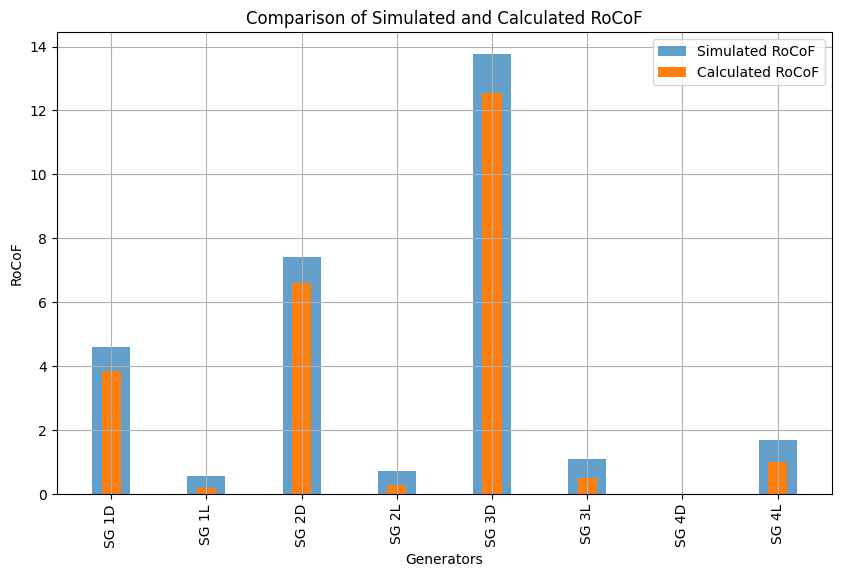

In [18]:
# Set the RoCoF value for the generator with GEN_OUT_NAME to 0
gen_out_idx = list(results.columns).index(GEN_OUT_NAME)
results.iloc[0, gen_out_idx] = 0

plt.figure(figsize=(10, 6))
plt.bar(results.columns, results.iloc[0] * -1, width=0.4, label='Simulated RoCoF', alpha=0.7)
plt.bar(df_rocof_ordered.columns, df_rocof_ordered.iloc[0], width=0.2, label='Calculated RoCoF', alpha=1)
plt.xlabel('Generators')
plt.ylabel('RoCoF')
plt.title('Comparison of Simulated and Calculated RoCoF')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

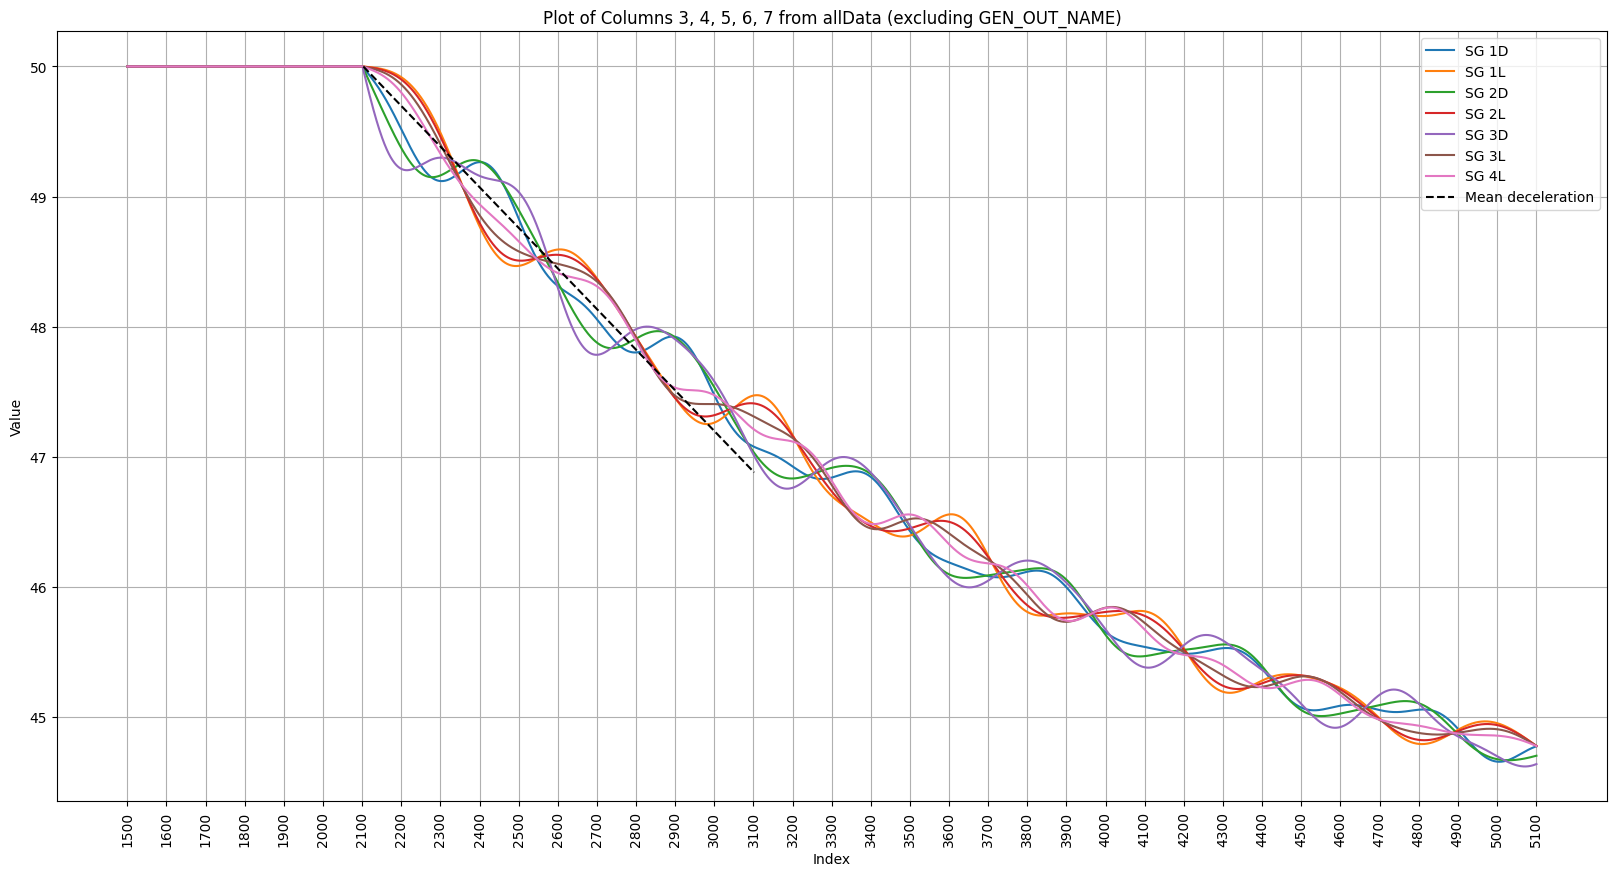

In [19]:
plt.figure(figsize=(20, 10))
# Exclude the column with name GEN_OUT_NAME
cols_to_plot = [col for col in allData.columns[1:9] if col != GEN_OUT_NAME]
for col in cols_to_plot:
    y = pd.to_numeric(allData[col], errors='coerce') * 50
    plt.plot(np.arange(1500, len(y)), y.values[1500:], label=col) # Hide first 1500 values
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Columns 3, 4, 5, 6, 7 from allData (excluding GEN_OUT_NAME)')
plt.grid(True)
plt.xticks(ticks=np.arange(1500, len(allData), 100), rotation=90)

# Add additional line with coefficient -0.004 starting at index 2103, cut off at 1000 total values
x_start = 2103
num_points = 1000
x_vals = np.arange(x_start, min(x_start + num_points, len(allData)))
y_init = 50
y_vals = y_init + (x_vals - x_start) * (-mean / 1000)
plt.plot(x_vals, y_vals, 'k--', label='Mean deceleration')

plt.legend()
plt.show()


In [ ]:
# Okej na tem mestu se mi zdi dobro vprašanje a moramo za SG 4, SG 5 in SG 6 upoštevati te najbolj začetne vrednosti ali tudi tiste po 2200 ms??
# Nevem pomojem začetne ker potem se itak vsi bolj kot ne ravnajo po mean deceleration

In [21]:
# Create a load flow object and execute
ldf: DataObject = app.GetFromStudyCase("ComLdf")
ldf.Execute() # type: ignore 

# Store results using dataclass
bus_load_flow_results: Dict[str, BusLoadFlowResult] = {}
for busbar in busbars:
    name = busbar.GetAttribute("loc_name")
    voltage = busbar.GetAttribute("m:u")
    angle = busbar.GetAttribute("m:phiu")
    
    bus_load_flow_results[name] = BusLoadFlowResult(
        name=name,
        voltage=voltage,
        angle=angle
    )

# Store load flow to Network object
network.read_load_flow_results(bus_load_flow_results)
print(len(network.load_flow_results))

13


In [22]:
from calculateRocof import calculateRocofValues
from typing import List
import pandas as pd

def calculate_rocofs_for_new_gen(app: PF.Application, allGenerators: List[DataObject], terminalName: str, admittanceMatrix: np.ndarray, network: Network):
    rocofList = []
    # for gen in allGenerators:
    for generator in network.synchronous_machines:
        # GEN = gen
        try:
            GEN: DataObject = next(gen for gen in allGenerators if gen.GetAttribute("loc_name") == generator.name)
        except StopIteration:
            print(f"Generator with name '{generator.name}' not found in allGenerators. Skipping.")
            continue
        rocofValues, generatorNames = calculateRocofValues(app, terminalName, GEN, admittanceMatrix, network)
        rocofList.append(rocofValues)

    return rocofList, generatorNames

# # Example usage
# rocofValues, generatorNames = calculate_rocofs_for_new_gen(app, allGenerators, "Term 1", Y_bus, network)

# # Convert to DataFrame for better readability and set column names
# df_rocofValues = pd.DataFrame(rocofValues, columns=generatorNames)
# df_rocofValues

In [23]:
# Candidate busbars for new generator
candidate_busbars = [None, "Term 1", "Term 2", "Term 3", "Term 4", "Term 5"]

# Calculate RoCoF impact for each candidate location
rocofValues = {}
for busbar in candidate_busbars:
    print(f"Calculating RoCoFs for new Generator on bus: {busbar}")
    rocofValues[busbar], generatorNames = calculate_rocofs_for_new_gen(app, allGenerators, busbar, Y_bus, network)
    # break

# print(rocofValues)

Calculating RoCoFs for new Generator on bus: None
Calculating RoCoFs for new Generator on bus: Term 1
Generator with name 'NEW SG' not found in allGenerators. Skipping.
Calculating RoCoFs for new Generator on bus: Term 2
Generator with name 'NEW SG' not found in allGenerators. Skipping.
Calculating RoCoFs for new Generator on bus: Term 3
Generator with name 'NEW SG' not found in allGenerators. Skipping.
Calculating RoCoFs for new Generator on bus: Term 4
Generator with name 'NEW SG' not found in allGenerators. Skipping.
Calculating RoCoFs for new Generator on bus: Term 5
Generator with name 'NEW SG' not found in allGenerators. Skipping.


In [24]:
import numpy as np

# Store max RoCoF values for each busbar
max_rocof_per_busbar = {}

# For each busbar configuration
for busbar, rocof_arrays in rocofValues.items():
    # Calculate the maximum RoCoF value for each outage scenario
    max_rocofs = []
    for rocof_array in rocof_arrays:
        # Exclude zeros (outage generator itself)
        non_zero_rocofs = rocof_array[rocof_array > 0]
        if len(non_zero_rocofs) > 0:
            max_rocofs.append(np.max(non_zero_rocofs))
    
    # Get the worst-case RoCoF for this busbar (max of all outage scenarios)
    max_rocof = np.max(max_rocofs)
    max_rocof_per_busbar[busbar] = max_rocof

# Find the busbar with the lowest maximum RoCoF
best_busbar = min(max_rocof_per_busbar, key=max_rocof_per_busbar.get)
best_max_rocof = max_rocof_per_busbar[best_busbar]

print(f"Maximum RoCoF values for each busbar configuration:")
for busbar, max_rocof in max_rocof_per_busbar.items():
    print(f"  {busbar if busbar else 'No additional generator'}: {max_rocof:.4f} Hz/s")
    
print(f"\nBest busbar: {best_busbar}")
print(f"Lowest maximum RoCoF: {best_max_rocof:.4f} Hz/s")

# Additional analysis - which outage scenario causes the worst-case RoCoF
for busbar, rocof_arrays in rocofValues.items():
    if busbar == best_busbar:
        max_val = -np.inf
        worst_scenario = -1
        
        for i, rocof_array in enumerate(rocof_arrays):
            non_zero_rocofs = rocof_array[rocof_array > 0]
            if len(non_zero_rocofs) > 0:
                current_max = np.max(non_zero_rocofs)
                if current_max > max_val:
                    max_val = current_max
                    worst_scenario = i
                    
        print(f"\nFor the best busbar ({best_busbar}), the worst-case RoCoF occurs during outage of generator {worst_scenario}")
        print(f"RoCoF values for this scenario: {rocofValues[best_busbar][worst_scenario]}")

Maximum RoCoF values for each busbar configuration:
  No additional generator: 12.5490 Hz/s
  Term 1: 12.1563 Hz/s
  Term 2: 12.2582 Hz/s
  Term 3: 12.3333 Hz/s
  Term 4: 12.3904 Hz/s
  Term 5: 12.4351 Hz/s

Best busbar: Term 1
Lowest maximum RoCoF: 12.1563 Hz/s

For the best busbar (Term 1), the worst-case RoCoF occurs during outage of generator 2
RoCoF values for this scenario: [12.15632016  6.13556211  0.          2.29194229  3.07026428  0.68368402
  0.34922298  0.18893166  0.12407248]


In [25]:
import numpy as np
from pulp import LpProblem, LpVariable, LpMinimize, LpBinary, lpSum, value, LpStatus

# Create the optimization model
model = LpProblem(name="RoCoF_Optimization", sense=LpMinimize)

# Binary decision variables: 1 if we place a generator at bus i, 0 otherwise
x = {bus: LpVariable(f"x_{bus}", cat=LpBinary) for bus in rocofValues.keys() if bus is not None}

# Add variable for None case (no new generator)
x[None] = LpVariable("x_None", cat=LpBinary)

# Variable for maximum RoCoF (this is what we want to minimize)
max_rocof = LpVariable("max_rocof", lowBound=0)

# Objective function: Minimize maximum RoCoF
model += max_rocof

# Constraint: We can only add at most one generator
model += lpSum(x.values()) == 1

# For each outage scenario and each generator, add constraint
for busbar in rocofValues:
    for scenario_idx, rocof_array in enumerate(rocofValues[busbar]):
        # For each scenario, get the maximum RoCoF (excluding zeros)
        non_zero_indices = np.where(rocof_array > 0)[0]
        if len(non_zero_indices) > 0:
            max_rocof_scenario = np.max(rocof_array[non_zero_indices])
            
            # Add constraint: max_rocof must be at least as large as this scenario's max RoCoF if this busbar is chosen
            model += max_rocof >= max_rocof_scenario * x[busbar]

# Solve the model
status = model.solve()

# Print results
print(f"Status: {LpStatus[model.status]}")

if model.status == 1:  # Optimal solution found
    print(f"\nOptimal maximum RoCoF: {value(max_rocof):.4f} Hz/s")
    print("Generator should be added to:")
    
    for bus in x:
        if value(x[bus]) > 0.5:  # Binary variable is 1
            busbar_name = bus if bus else "No additional generator"
            print(f"- {busbar_name}")
            
            # Print the RoCoF values for this configuration
            if bus in rocofValues:
                print("\nRoCoF values for each outage scenario with this configuration:")
                for i, rocof_array in enumerate(rocofValues[bus]):
                    print(f"Outage {i}: {rocof_array}")

Status: Optimal

Optimal maximum RoCoF: 12.1563 Hz/s
Generator should be added to:
- Term 1

RoCoF values for each outage scenario with this configuration:
Outage 0: [0.         7.30061766 9.68380184 2.73448694 3.66227002 0.81971105
 0.42027627 0.22833206 0.15050416]
Outage 1: [6.82301081 0.         4.56787884 4.63442043 6.20519574 1.39723234
 0.71948624 0.39278177 0.25999382]
Outage 2: [12.15632016  6.13556211  0.          2.29194229  3.07026428  0.68368402
  0.34922298  0.18893166  0.12407248]
Outage 3: [2.47600408 4.49008413 1.65319067 0.         8.64029827 3.88428876
 2.01280748 1.1064961  0.73683051]
Outage 4: [3.26506821 5.91944415 2.18052676 8.50736624 0.         2.57834042
 1.33288927 0.73080698 0.48555797]
Outage 5: [0.81320936 1.48317963 0.54030722 4.25576446 2.86906204 0.
 7.83754523 4.31893944 2.88199262]
Outage 6: [0.40624127 0.74414096 0.26890307 2.14870062 1.44511148 7.63638221
 0.         7.39936804 4.95115235]
Outage 7: [0.23148003 0.42607053 0.15257913 1.23885653 0.83

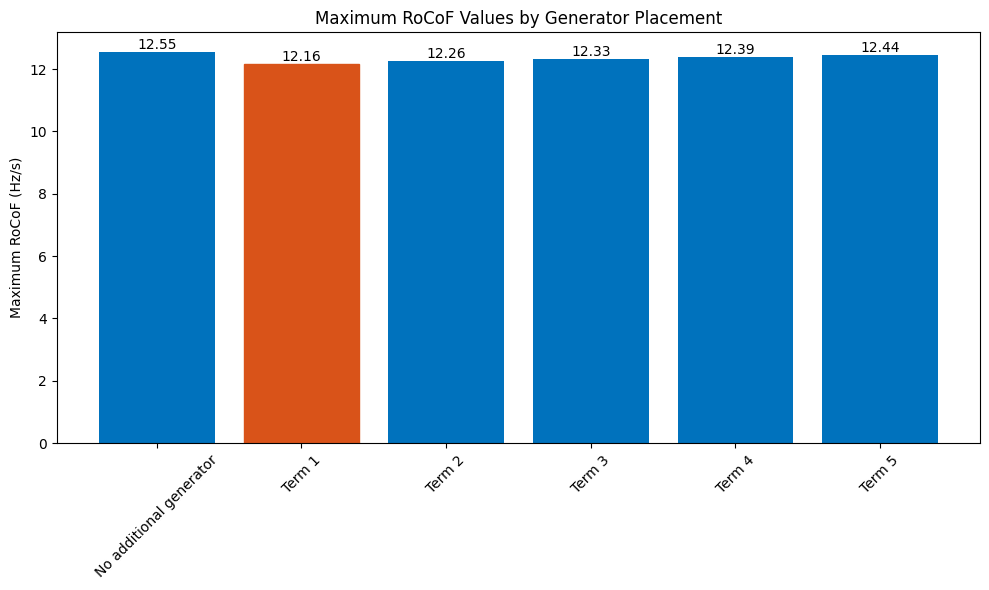

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart comparing the maximum RoCoF values
plt.figure(figsize=(10, 6))
busbars = list(max_rocof_per_busbar.keys())
values = list(max_rocof_per_busbar.values())

# Label for display
labels = [b if b else "No additional generator" for b in busbars]

matlab_blue = '#0072BD'
matlab_orange = '#D95319'

bars = plt.bar(range(len(busbars)), values, color=matlab_blue)
plt.xticks(range(len(busbars)), labels, rotation=45)
plt.ylabel('Maximum RoCoF (Hz/s)')
plt.title('Maximum RoCoF Values by Generator Placement')
plt.grid(axis='y', linestyle='--', alpha=0.7)

best_idx = busbars.index(best_busbar)
bars[best_idx].set_color(matlab_orange)

# Add values on top of each bar
for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.grid(False)
plt.show()